In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv

import ta as ta
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime

from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import *

from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import joblib


def preparar_dados_para_treinamento(anteriores,base_treinamento_normalizada):

    previsores = []
    preco_real = []

    for i in range(anteriores,len(base_treinamento_normalizada)):

        previsores.append(base_treinamento_normalizada[i-anteriores:i,0])
        preco_real.append(base_treinamento_normalizada[i,0])

    previsores,preco_real = np.array(previsores),np.array(preco_real)
    previsores = previsores
    
    return previsores,preco_real

def GetTsi(base,gaussian_knots,gaussian_sigma,ewm_span=20):
    
    tsi_config=[25,13]

    resultados_tsi = ta.momentum.TSIIndicator(base["Close"],tsi_config[0],tsi_config[1],False)

    tsi_df = pd.DataFrame(resultados_tsi.tsi())
    
    tsi_df.dropna(inplace=True)
    
    #Suavizando TSI com médias móveis exponenciais
    tsi_df["ewm"] = tsi_df['tsi'].ewm(span = ewm_span).mean()*1.2
    #------------------------------------------
    
    #Suavizanto TSI com gaussian smoother
    tsi_np = tsi_df["tsi"].to_numpy()
    tsi_np.reshape(1,len(tsi_np))

    smoother = GaussianSmoother(n_knots=gaussian_knots, sigma=gaussian_sigma)
    smoother.smooth(tsi_np)

    tsi_df["gaussian"] = smoother.smooth_data[0]
    #------------------------------------------
    
    return tsi_df

def GetRoc(base,gaussian_knots,gaussian_sigma,ewm_span=20):
    
    roc_config=[12]

    resultados_roc = ta.momentum.ROCIndicator(base["Close"],roc_config[0],False)
    
    roc_df = pd.DataFrame(resultados_roc.roc(),columns=["roc"])
    
    roc_df.dropna(inplace=True)
    
    #Suavizando ROC com médias móveis exponenciais
    roc_df["ewm"] = roc_df['roc'].ewm(span = ewm_span).mean()*1.2
    
    #Suavizanto ROC com gaussian smoother
    roc_np = roc_df["roc"].to_numpy()
    roc_np.reshape(1,len(roc_np))

    smoother = GaussianSmoother(n_knots=gaussian_knots, sigma=gaussian_sigma)
    smoother.smooth(roc_np)

    roc_df["gaussian"] = smoother.smooth_data[0]
    #------------------------------------------
    
    return roc_df

def Normalizar(Oscilador,coluna):
    
    normalizador = MinMaxScaler(feature_range=(0,1))
    
    if coluna == "tsi":
        Oscilador_treinamento = Oscilador.iloc[:,0:1].values
        
    if coluna == "ewm":
        Oscilador_treinamento = Oscilador.iloc[:,1:2].values
        
    if coluna == "gaussian":
        Oscilador_treinamento = Oscilador.iloc[:,2:3].values
        
    Oscilador_normalizado = normalizador.fit_transform(Oscilador_treinamento)
    
    return Oscilador_normalizado


def Criar_modelo_randomForest(base,anteriores_,filepath,knots_=60,sigma_=0.0003,n_estimators_=100,max_depth_=None,min_samples_split_=2,min_samples_leaf_=1):
    
    #Extrai o tsi
    tsi = GetTsi(base,knots_,sigma_)
    #--------------------------------


    #Faz a normalização do gaussian do tsi
    normalizado = Normalizar(tsi,"gaussian")
    #--------------------------------


    X_train, y_train = preparar_dados_para_treinamento(anteriores_,normalizado)

    forest_model = RandomForestRegressor(
        random_state=1,
        n_estimators=n_estimators_,
        max_depth=max_depth_,
        min_samples_split=min_samples_split_,
        min_samples_leaf=min_samples_leaf_)
    
    
    forest_model.fit(X_train, y_train)
    
    #joblib.dump(forest_model, "RandomForest_4.joblib")
    joblib.dump(forest_model, filepath)
    
    print("Modelo pronto ",filepath)
    
    return forest_model


def Realizar_previsoes_randomForest(qtd_previsoes,base,anteriores,modelo,knots=60,sigma=0.0003):

    ultimos_valores = base.tail(anteriores+37)

    tsi_atual = GetTsi(ultimos_valores,knots,sigma)

    normalizado = Normalizar(tsi_atual,"gaussian")

    normalizado_reshape =normalizado.reshape(1,-1)

    lista_previsoes = list()

    i = 0

    while i < qtd_previsoes:

        previsao = modelo.predict(normalizado_reshape)

        lista_previsoes.append(previsao)

        normalizado_reshape =  np.append(normalizado_reshape,previsao)

        normalizado_reshape = np.delete(normalizado_reshape,0)

        normalizado_reshape =normalizado_reshape.reshape(1,-1)

        i+=1
    
    return lista_previsoes



def Carregar_modelo_randomForest(filepath):
    
    modelo = joblib.load(filepath)
    
    print("Modelo carregado")
    
    return modelo




In [10]:
ticker ="PETR3.SA"

df = yf.download(ticker)

base = df["2018":]


fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name="Ação",
        x=base.index,
        y=base["Close"],
        line=dict(color='blue', width=1))
)

[*********************100%***********************]  1 of 1 completed


In [76]:
#TSI

tsi_config=[25,13]
resultados_tsi = ta.momentum.TSIIndicator(base["Close"],tsi_config[0],tsi_config[1],False)

resultados_tsi.tsi().dropna(inplace=True)


#Gaussian TSI
resultados_tsi_sem_null = resultados_tsi.tsi().dropna()

tsi_np = resultados_tsi_sem_null.to_numpy()

tsi_np = tsi_np.reshape(1,len(tsi_np))


smoother_tsi = GaussianSmoother(n_knots=60, sigma=0.0003)
smoother_tsi.smooth(tsi_np)


fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name="TSI",
        x=base.tail(len(resultados_tsi_sem_null)).index,
        y=resultados_tsi_sem_null,
        line=dict(color='blue', width=1))
)

fig.add_trace(
    go.Scatter(
        x=base.tail(len(resultados_tsi_sem_null)).index,
        y=smoother_tsi.smooth_data[0],
        mode='lines',
        name='Gaussian',
        line=dict(color="orange"))
)





fig.add_hline(y=0,line_color="blue",line_width=1, line_dash="dash")
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

In [100]:
ticker ="PETR3.SA"

df = yf.download(ticker)

base = df["2018":]


#Atributos
anteriores = 500
knots = 60
sigma = 0.0003
n_estimators_ = 500
max_depth_ = None
min_samples_split_ = 2
min_samples_leaf_ = 1
filepath_ = "PETR3_RF_10.joblib"


#TREINAR O MODELO
forest_model = Criar_modelo_randomForest(
    base,
    anteriores,
    filepath_,
    knots,
    sigma,
    n_estimators_,
    max_depth_,
    min_samples_split_,
    min_samples_leaf_)

[*********************100%***********************]  1 of 1 completed
Modelo pronto  PETR3_RF_10.joblib


In [87]:
#REALIZAR PREVISÕES

ticker ="VIVA3.SA"

df = yf.download(ticker)

base = df["2018":]


modelo_rf1 = Carregar_modelo_randomForest("PETR3_RF_1.joblib")
modelo_rf2 = Carregar_modelo_randomForest("PETR3_RF_2.joblib")
modelo_rf3 = Carregar_modelo_randomForest("PETR3_RF_3.joblib")
modelo_rf4 = Carregar_modelo_randomForest("PETR3_RF_4.joblib")
modelo_rf5 = Carregar_modelo_randomForest("PETR3_RF_5.joblib")
modelo_rf6 = Carregar_modelo_randomForest("PETR3_RF_6.joblib")
modelo_rf7 = Carregar_modelo_randomForest("PETR3_RF_7.joblib")
modelo_rf8 = Carregar_modelo_randomForest("PETR3_RF_8.joblib")
modelo_rf9 = Carregar_modelo_randomForest("PETR3_RF_9.joblib")
modelo_rf10 = Carregar_modelo_randomForest("PETR3_RF_10.joblib")


[*********************100%***********************]  1 of 1 completed
Modelo carregado
Modelo carregado
Modelo carregado
Modelo carregado
Modelo carregado
Modelo carregado
Modelo carregado
Modelo carregado


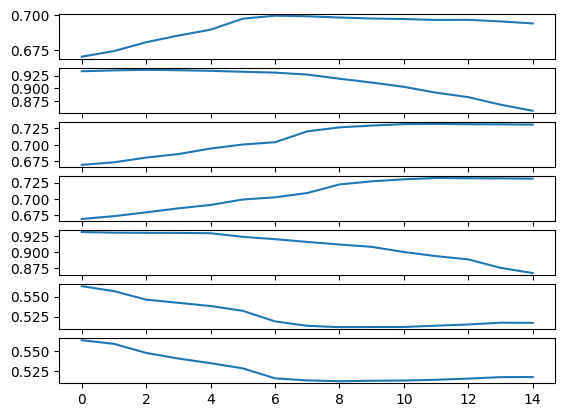

In [98]:
qtd_previsoes = 15

knots = 60

sigma = 0.0003

base_teste = base[:"2022-03-03"]


lista_previsoes1 = Realizar_previsoes_randomForest(qtd_previsoes,base_teste,180,modelo_rf1,knots,sigma)
lista_previsoes2 = Realizar_previsoes_randomForest(qtd_previsoes,base_teste,90,modelo_rf2,knots,sigma)
lista_previsoes3 = Realizar_previsoes_randomForest(qtd_previsoes,base_teste,180,modelo_rf3,knots,sigma)
lista_previsoes4 = Realizar_previsoes_randomForest(qtd_previsoes,base_teste,180,modelo_rf4,knots,sigma)
lista_previsoes5 = Realizar_previsoes_randomForest(qtd_previsoes,base_teste,90,modelo_rf5,knots,sigma)
#lista_previsoes6 = Realizar_previsoes_randomForest(qtd_previsoes,base,50,modelo_rf6,knots,sigma)
lista_previsoes7 = Realizar_previsoes_randomForest(qtd_previsoes,base_teste,300,modelo_rf7,knots,sigma)
lista_previsoes8 = Realizar_previsoes_randomForest(qtd_previsoes,base_teste,300,modelo_rf8,knots,sigma)
lista_previsoes9 = Realizar_previsoes_randomForest(qtd_previsoes,base_teste,500,modelo_rf9,knots,sigma)
lista_previsoes10 = Realizar_previsoes_randomForest(qtd_previsoes,base_teste,500,modelo_rf10,knots,sigma)


x = np.array(range(len(lista_previsoes1)))
y = np.array(lista_previsoes1)

plt.subplot(9, 1, 1)
plt.plot(x,y)


x = np.array(range(len(lista_previsoes2)))
y = np.array(lista_previsoes2)

plt.subplot(9, 1, 2)
plt.plot(x,y)


x = np.array(range(len(lista_previsoes3)))
y = np.array(lista_previsoes3)

plt.subplot(9, 1, 3)
plt.plot(x,y)


x = np.array(range(len(lista_previsoes4)))
y = np.array(lista_previsoes4)

plt.subplot(9, 1, 4)
plt.plot(x,y)


x = np.array(range(len(lista_previsoes5)))
y = np.array(lista_previsoes5)

plt.subplot(9, 1, 5)
plt.plot(x,y)


x = np.array(range(len(lista_previsoes7)))
y = np.array(lista_previsoes7)

plt.subplot(9, 1, 6)
plt.plot(x,y)


x = np.array(range(len(lista_previsoes8)))
y = np.array(lista_previsoes8)

plt.subplot(9, 1, 7)
plt.plot(x,y)


x = np.array(range(len(lista_previsoes9)))
y = np.array(lista_previsoes8)

plt.subplot(9, 1, 8)
plt.plot(x,y)


x = np.array(range(len(lista_previsoes10)))
y = np.array(lista_previsoes10)

plt.subplot(9, 1, 9)
plt.plot(x,y)